In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Assets/tf_weights'

In [2]:
import importlib

import helper_funcs
importlib.reload(helper_funcs)

from helper_funcs import plot_nice_bar

In [3]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [4]:
folders = ['test','test-1','test-2','test-3']
folders = [f'test-{i}' for i in range(8)]
np.array(folders)

array(['test-0', 'test-1', 'test-2', 'test-3', 'test-4', 'test-5',
       'test-6', 'test-7'], dtype='<U6')

In [5]:
lbls = ['CMAT','Recon','DMAT','BG', 'SL',]

In [6]:
arrays_test = [pickle.load(open(os.path.join(folder,'rsa_res_test.pkl'),'rb')) for folder in folders]
arrays_train = [pickle.load(open(os.path.join(folder,'rsa_res_train.pkl'),'rb')) for folder in folders]

In [7]:
keys = list(arrays_train[0].keys())
np.array(keys)

array(['dataset_id', 'siteID', 'age', 'gender', 'fiq', 'DSMIV',
       'ados_total', 'ados_social', 'ados_comm', 'ados_rrb'], dtype='<U11')

In [8]:
plot_arr_train = np.zeros((len(arrays_train),len(keys),5))
plot_arr_test = np.zeros((len(arrays_train),len(keys),5))

for i,_ in enumerate(arrays_train):
    for j,key in enumerate(keys):
        plot_arr_train[i,j,:] = arrays_train[i][key][0,:]
        plot_arr_test[i,j,:] = arrays_test[i][key][0,:]

In [9]:
rel_rsa_res_test = dict()
rel_rsa_res_train = dict()

for i,key in enumerate(keys):
    rel_rsa_res_train[key] = plot_arr_train[:,i,:]
    rel_rsa_res_test[key] = plot_arr_test[:,i,:]

In [10]:
len(arrays_train)

8

In [96]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True,lbls=['VAE','BG','SL']):
    
    from matplotlib import pyplot as plt
    import numpy as np
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = lbls.copy()
    
    plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(len(xlbls))])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = lbls.copy()
        for i in range(1,c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')
    
    pairwise_t = np.zeros((c,c))
    pairwise_p = np.zeros((c,c))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    for i in range(c):
        for j in range(c):
            t,p = ttest(data[:,i],data[:,j])
            mnames = lbls.copy()
            pairwise_t[i,j] = t
            pairwise_p[i,j] = p

            if report_t==True:
                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')


    comps = [[3,4]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]] < pairwise_sample_thresh)[0])
            #max_y = new_y[-1] + (comp_idx * .1)
            max_y = max(new_y)
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y * 1.025,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

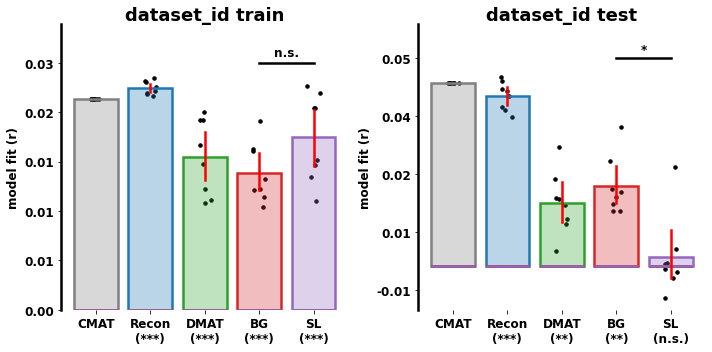

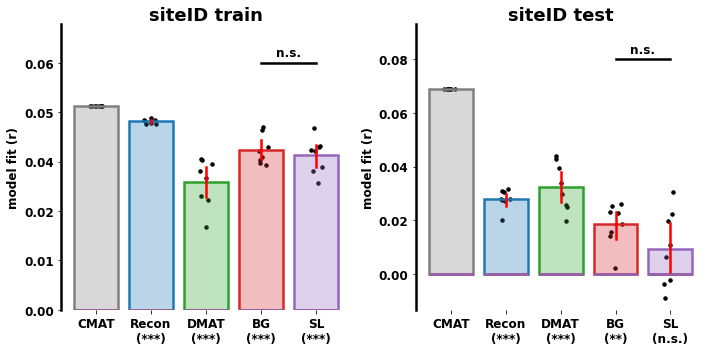

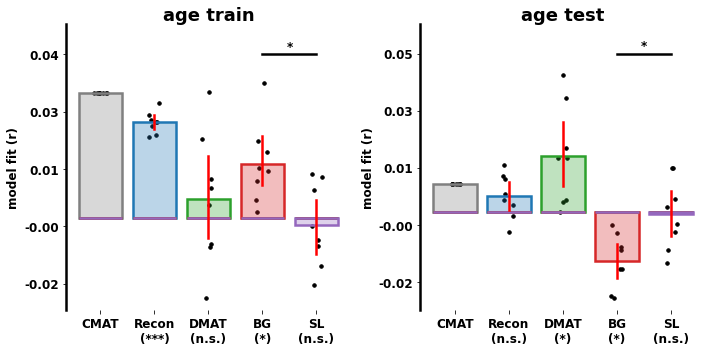

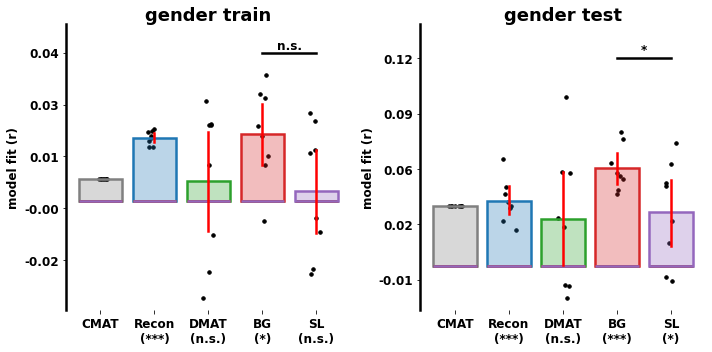

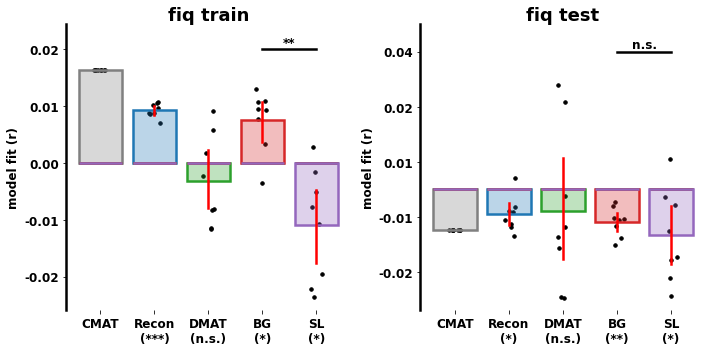

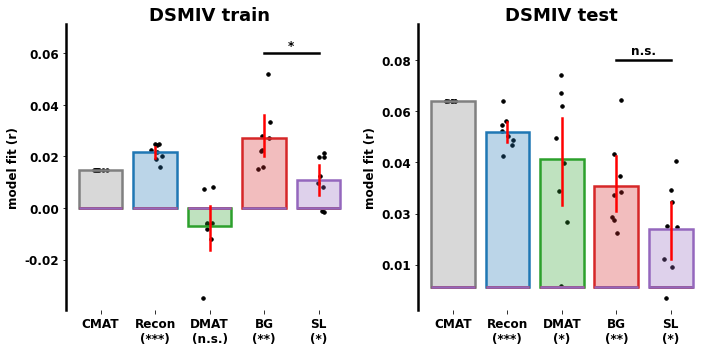

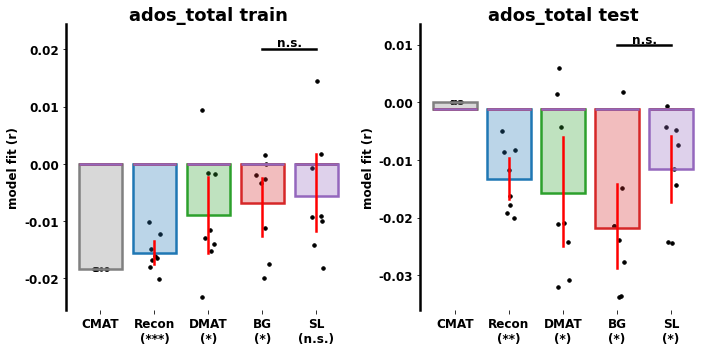

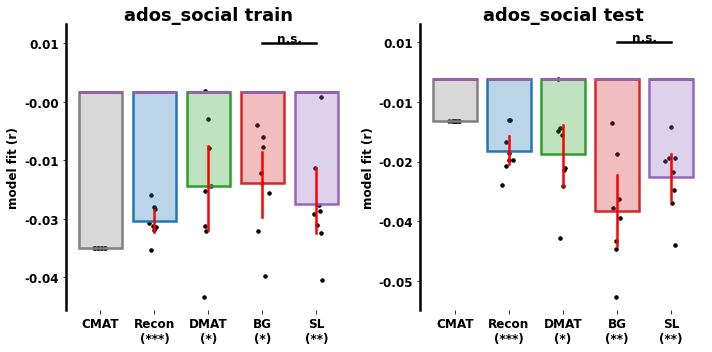

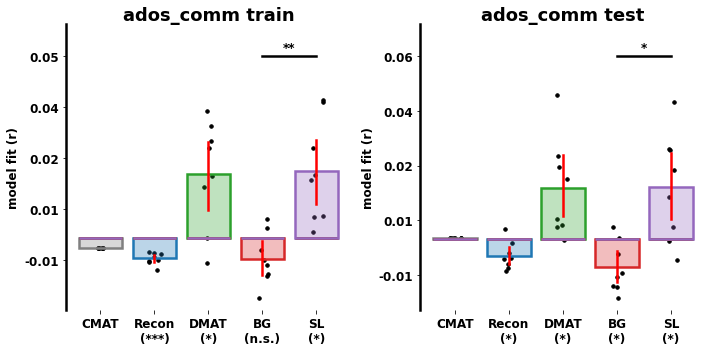

In [ ]:
for key in keys:
    
    plt.figure(figsize=(10,5))
    
    ax = plt.subplot(1,2,1)
    plot_nice_bar(key,rel_rsa_res_train,ax=ax,figsize=None,dpi=300,fontsize=12,fontsize_star=12,fontweight='bold',line_width=2.5,marker_size=12,title=key+' train',lbls=lbls,do_pairwise_stars=True,report_t=False)
    
    ax = plt.subplot(1,2,2)
    plot_nice_bar(key,rel_rsa_res_test,ax=ax,figsize=None,dpi=300,fontsize=12,fontsize_star=12,fontweight='bold',line_width=2.5,marker_size=12,title=key+' test',lbls=lbls,do_pairwise_stars=True,report_t=False)
    
    plt.tight_layout()